# Telco Churn Project




## Why are our customers churning?
### Look for any groupings (if any) that indicate a customer is more likely to churn.

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from scipy import stats

# visualizing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('figure', figsize=(13, 10))
plt.rc('font', size=14)

# preparing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# modeling and evaluating
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix

# turn off warnings
import warnings
warnings.filterwarnings("ignore")

# acquiring
# from explore import anatomy_of_a_figure
from env import host, user, password
from pydataset import data

In [2]:
from acquire import get_db
from acquire import get_telco_data
from prepare import prep_telco_data
from prepare import prep_telco_data_all

End of file.


In [3]:
telco = get_telco_data()

In [103]:
# Summarizing the dataframe:

print(telco.shape)
print(telco.info())

(7043, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7043 non-null   object 
 1   gender                    7043 non-null   object 
 2   senior_citizen            7043 non-null   int64  
 3   partner                   7043 non-null   object 
 4   dependents                7043 non-null   object 
 5   tenure                    7043 non-null   int64  
 6   phone_service             7043 non-null   object 
 7   multiple_lines            7043 non-null   object 
 8   internet_service_type_id  7043 non-null   int64  
 9   online_security           7043 non-null   object 
 10  online_backup             7043 non-null   object 
 11  device_protection         7043 non-null   object 
 12  tech_support              7043 non-null   object 
 13  streaming_tv              7043 non-null   object 
 1

In [7]:
# .describe gives summary data stats of the dataframe. Note that many of the categorical variables we want to test, such as payment type, have not yet been prepped so they aren't showing up.

telco.describe()

,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,1.872923,1.690473,2.315633,64.761692
std,0.368612,24.559481,0.737796,0.833755,1.148907,30.090047
min,0.000000,0.000000,1.000000,1.000000,1.000000,18.250000
25%,0.000000,9.000000,1.000000,1.000000,1.000000,35.500000
50%,0.000000,29.000000,2.000000,1.000000,2.000000,70.350000
75%,0.000000,55.000000,2.000000,2.000000,3.000000,89.850000
max,1.000000,72.000000,3.000000,3.000000,4.000000,118.750000


In [8]:
len(telco.columns)

# There are currently 24 total columns in the dataframe, before prepping (and potentially adding more columns).

24

In [9]:
# Using value_counts() and the normalize argument within the function to find the overall churn rate across all variables.

telco.churn.value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: churn, dtype: float64

In [10]:
# Pandas wasn't showing all the columns in the dataframe, so I expanded the number of default columns Pandas would display.
# Exocortext: https://www.mikulskibartosz.name/how-to-display-all-columns-of-a-pandas-dataframe-in-jupyter-notebook/

pd.set_option('display.max_columns', 999)

# Prepare Data

#### Columns that I need to change to numerical:
- Gender --> new column "is_female" Female = 1, Male = 0
- online_security thru streaming_movies needs to be turned into a column of discreet variables.
- churn needs to be turned into a discreet variable column. Not churned = 0, churned = 1
- partner and dependents need to become discreet if I use them. 

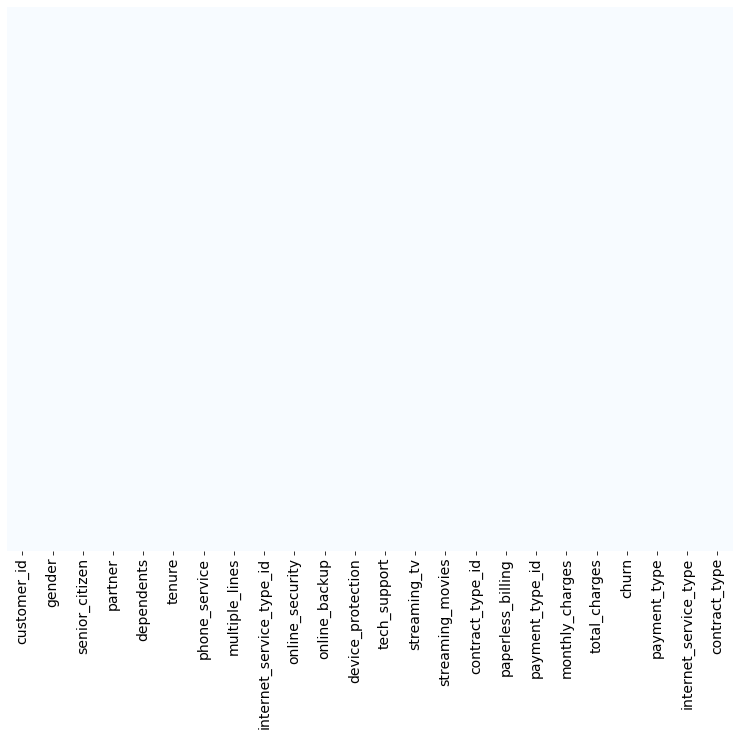

In [11]:
# A quick visualization technique using a heatmap shows there are no missing values in the columns. Meaning we have fairly clean data.

sns.heatmap(telco.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')

In [12]:
# Further confirmation there are no missing values that need to be imputed.

telco.isna().sum()

customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
internet_service_type_id    0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
contract_type_id            0
paperless_billing           0
payment_type_id             0
monthly_charges             0
total_charges               0
churn                       0
payment_type                0
internet_service_type       0
contract_type               0
dtype: int64

In [13]:
# However, some of these value may need to be normalized/stratified depending on which columns I'll need to use.

### Last step: get my split my data from my prepare.py file:

In [15]:
train, validate, test = prep_telco_data(get_telco_data())

In [16]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,payment_type,internet_service_type,contract_type,month_to_month,one_year,two_year,dsl_internet,fiber_internet,no_internet,is_female,is_automatic,churned
5710,6013-BHCAW,Male,0,1,1,61,1,1,1,0,0,1,1,1,0,3,1,3,81.00,4976.15,No,Bank transfer (automatic),DSL,Two year,0,0,1,1,0,0,0,1,0
4465,0409-WTMPL,Female,0,1,0,58,1,1,2,1,1,1,0,1,0,2,1,4,110.65,6526.65,No,Credit card (automatic),Fiber optic,One year,0,1,0,0,1,0,1,1,0
5017,1085-LDWAM,Female,0,1,1,69,1,0,3,0,0,0,0,0,0,2,1,4,20.35,1442.65,No,Credit card (automatic),None,One year,0,1,0,0,0,1,1,1,0
3521,3039-MJSLN,Male,0,0,1,3,1,0,3,0,0,0,0,0,0,1,0,3,20.20,50.60,No,Bank transfer (automatic),None,Month-to-month,1,0,0,0,0,1,0,1,0
3828,9046-JBFWA,Male,0,0,1,27,1,0,3,0,0,0,0,0,0,1,0,2,19.15,537.35,No,Mailed check,None,Month-to-month,1,0,0,0,0,1,0,0,0


# Exploratory Phase

#### Goals of Explore phase:
- Answer the key questions
- Answer hypotheses
- Determine drivers of churn
- Set the baseline model



#### Goal is to find drivers of churn, and I will need to establish a baseline against which to compare my models.
A simple way to do this is to create a baseline model that simply picks the most commonly occuring observation every time.

In [17]:
# Baseline question: Did a customer churn? Simple find the %s of customers that churned or didn't churn.

# Overall churn across all tenures and customers:
train.churn.value_counts(normalize = True)

No     0.73472
Yes    0.26528
Name: churn, dtype: float64

In [18]:
# Exploring churn rates by tenure. Dividing by year:

# Creating a separate dataframe from my train dataset for taking a look at number of tenure years:
df_explore = train
df_explore['t_yrs'] = round(df_explore.tenure / 12, 2)

# Chohort of 1 year of tenure:
year_one = df_explore.t_yrs <=1
year_test = df_explore[year_one]
year_test.churn.value_counts(normalize = True)

No     0.533552
Yes    0.466448
Name: churn, dtype: float64

In [19]:
# Chohort of 2 years of tenure:
year_two = (df_explore.t_yrs >1) & (df_explore.t_yrs <=2)
year_test = df_explore[year_two]
year_test.churn.value_counts(normalize = True)

No     0.724541
Yes    0.275459
Name: churn, dtype: float64

In [20]:
# Chohort of 3 years of tenure:
year_three = (df_explore.t_yrs >2) & (df_explore.t_yrs <=3)
year_test = df_explore[year_three]
year_test.churn.value_counts(normalize = True)

No     0.755889
Yes    0.244111
Name: churn, dtype: float64

In [21]:
# Chohort of greater than 3 years of tenure:
year_three = (df_explore.t_yrs >3)
year_test = df_explore[year_three]
year_test.churn.value_counts(normalize = True)

No     0.880967
Yes    0.119033
Name: churn, dtype: float64

#### Takeaways:
- It appears that as tenure increases, churn decreases.
- Highest amount of churn is in the 1 year or less tenure, which makes sense since most of the churn is occuring in the month to month contract types.

In [22]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,payment_type,internet_service_type,contract_type,month_to_month,one_year,two_year,dsl_internet,fiber_internet,no_internet,is_female,is_automatic,churned,t_yrs
5710,6013-BHCAW,Male,0,1,1,61,1,1,1,0,0,1,1,1,0,3,1,3,81.00,4976.15,No,Bank transfer (automatic),DSL,Two year,0,0,1,1,0,0,0,1,0,5.08
4465,0409-WTMPL,Female,0,1,0,58,1,1,2,1,1,1,0,1,0,2,1,4,110.65,6526.65,No,Credit card (automatic),Fiber optic,One year,0,1,0,0,1,0,1,1,0,4.83
5017,1085-LDWAM,Female,0,1,1,69,1,0,3,0,0,0,0,0,0,2,1,4,20.35,1442.65,No,Credit card (automatic),None,One year,0,1,0,0,0,1,1,1,0,5.75
3521,3039-MJSLN,Male,0,0,1,3,1,0,3,0,0,0,0,0,0,1,0,3,20.20,50.60,No,Bank transfer (automatic),None,Month-to-month,1,0,0,0,0,1,0,1,0,0.25
3828,9046-JBFWA,Male,0,0,1,27,1,0,3,0,0,0,0,0,0,1,0,2,19.15,537.35,No,Mailed check,None,Month-to-month,1,0,0,0,0,1,0,0,0,2.25


Charting the `monthly_charges` vs `contract_type`, and further dividing by whether or not they churned. Making sure to use my train data.



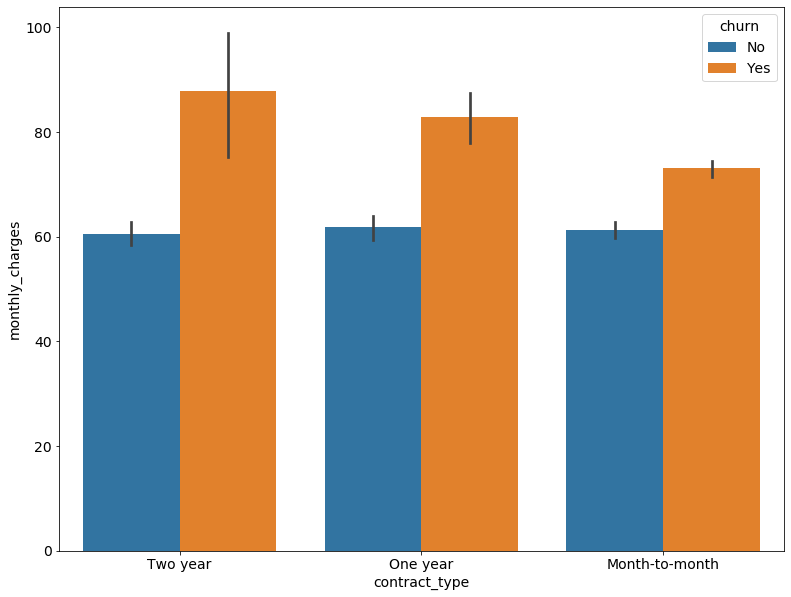

In [110]:
sns.barplot(x = 'contract_type', y = 'monthly_charges', hue = 'churn', data = train)
plt.show()

I will probably end up using the `is_automatic` variable if my hypothesis testing shows it is an independent variable.

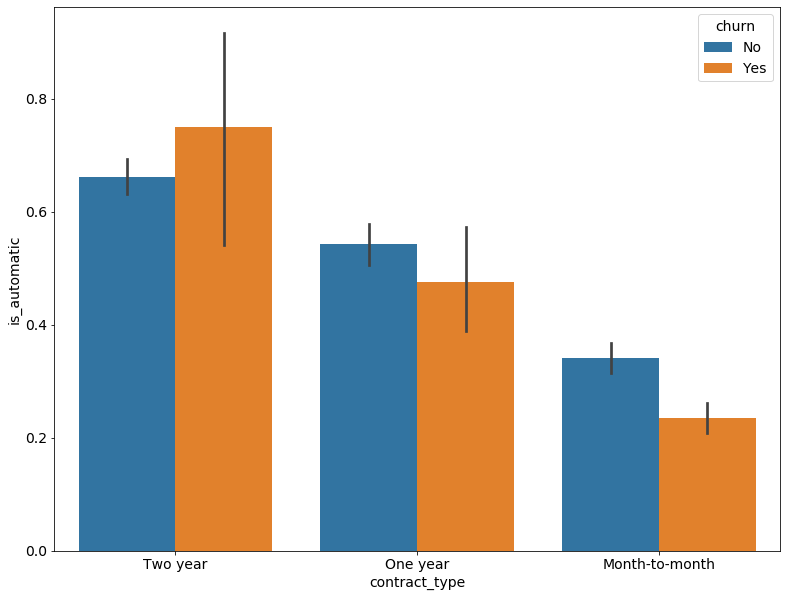

In [109]:
sns.barplot(x = 'contract_type', y = 'is_automatic', hue = 'churn', data = train)
plt.show()

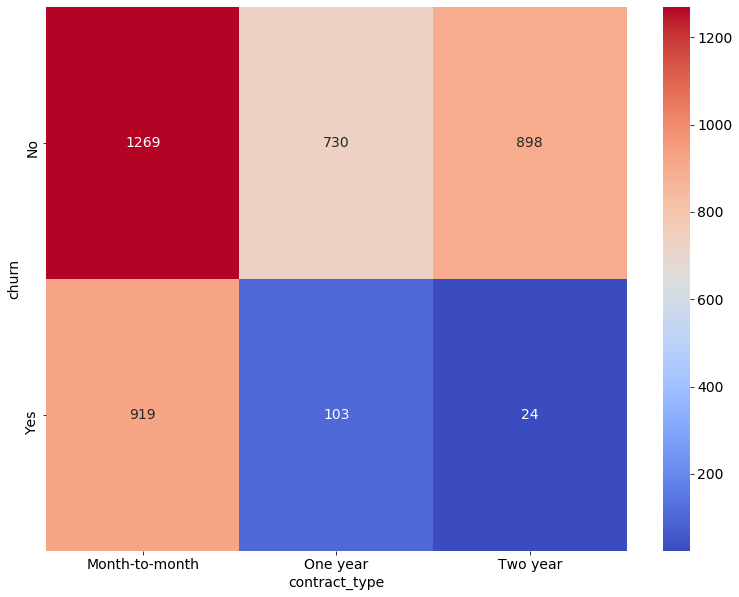

In [104]:
# Using a heatmap to discover if the independent variables I've selected are correlated in any way.

ctab = pd.crosstab(train.churn, train['contract_type'])

sns.heatmap(ctab, annot = True, cmap = 'coolwarm', fmt = 'd')
plt.show()

Comparing the churn `total_charges` variable:

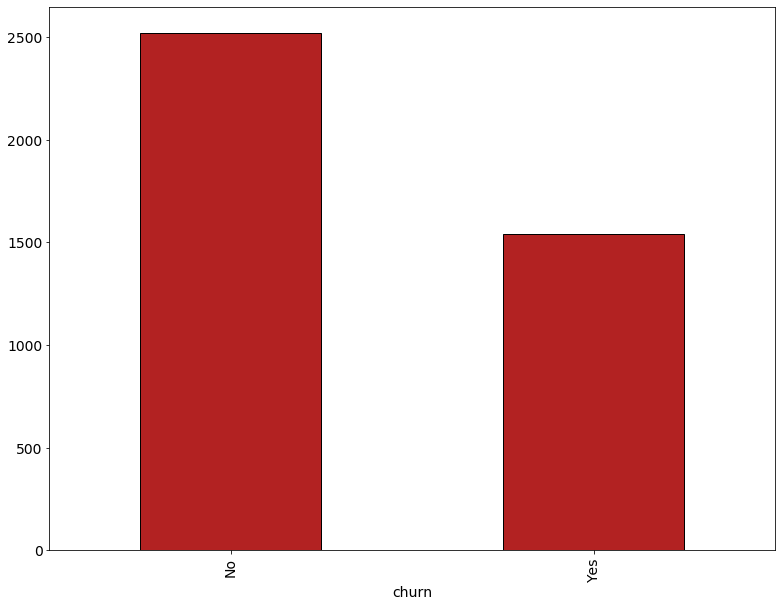

In [111]:
train.groupby('churn').total_charges.mean().plot.bar(color = 'firebrick', ec = 'black')
plt.show()

Doing the same comparison but using the `monthly_charges` variable. It appears that the tendancy towards churn for using `monthly_charges` is reversed.

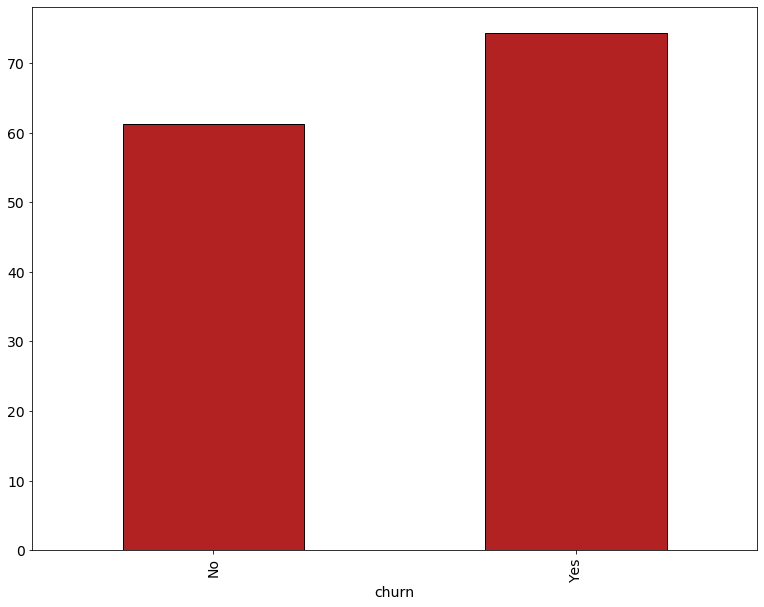

In [112]:
train.groupby('churn').monthly_charges.mean().plot.bar(color = 'firebrick', ec = 'black')
plt.show()

**Using a heatmap to illustrate correlation between some of the independent variables that have potential to be used in the models.**

In [26]:
# Showing the correlation between some of the independent variables I've decided to to look at.
telco_heatmap = df_explore[['is_female', 'senior_citizen', 'paperless_billing', 'is_automatic', 'churned']]

corr = telco_heatmap.corr()
corr

,is_female,senior_citizen,paperless_billing,is_automatic,churned
is_female,1.000000,-0.021800,0.011831,0.019679,-0.015909
senior_citizen,-0.021800,1.000000,0.159859,-0.043700,0.164965
paperless_billing,0.011831,0.159859,1.000000,-0.011063,0.190913
is_automatic,0.019679,-0.043700,-0.011063,1.000000,-0.196905
churned,-0.015909,0.164965,0.190913,-0.196905,1.000000


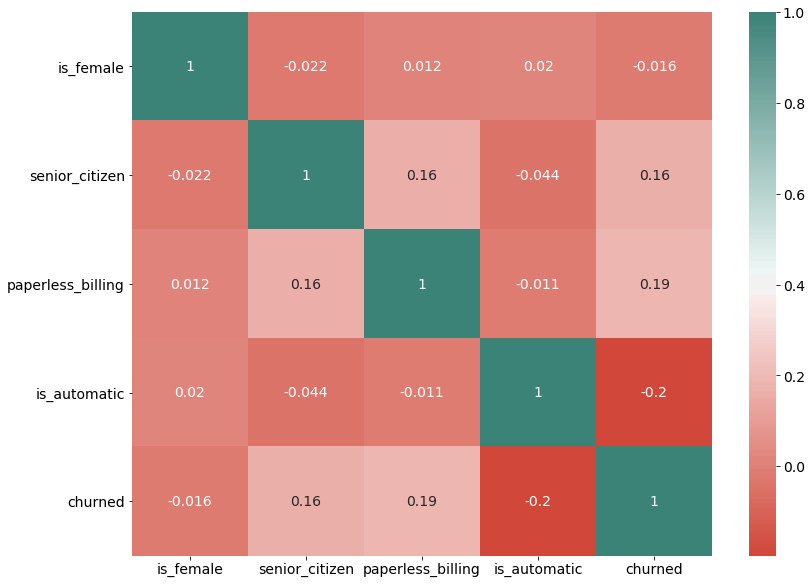

In [119]:
cmap = sns.diverging_palette(15, 175, as_cmap = True)

sns.heatmap(corr, annot = True, cmap = cmap)
plt.show()

#### Results:
- Gender doesn't appear to be a driver for churn, at **-0.016**
- Automatic payments appear to have a strong negative correlation to whether someone churned, at **-0.2**
- Paperless Billing, related to Automatic payment types, also has a stronger positive correlation at **0.19**
- Senior citizen has a stronger correlation, at **+.16**

**Second heatmap. I'll draw the models' independent variables from this pool of features.**

In [113]:
telco_heatmap2 = df_explore[['monthly_charges', 'total_charges', 'phone_service', 'month_to_month', 'one_year', 'two_year', 'dsl_internet', 'tech_support', 'is_automatic', 'churned']]

corr2 = telco_heatmap2.corr()
corr2

,monthly_charges,total_charges,phone_service,month_to_month,one_year,two_year,dsl_internet,tech_support,is_automatic,churned
monthly_charges,1.000000,0.655606,0.247370,0.056906,-0.005278,-0.061726,-0.167968,0.335921,0.058448,0.192753
total_charges,0.655606,1.000000,0.108997,-0.434761,0.161718,0.354509,-0.071424,0.422185,0.302967,-0.192111
phone_service,0.247370,0.108997,1.000000,-0.000034,0.003822,-0.003646,-0.451276,-0.082523,-0.011405,0.003827
month_to_month,0.056906,-0.434761,-0.000034,1.000000,-0.577866,-0.616844,-0.048414,-0.280624,-0.307156,0.391353
one_year,-0.005278,0.161718,0.003822,-0.577866,1.000000,-0.285912,0.037463,0.088394,0.107058,-0.166030
two_year,-0.061726,0.354509,-0.003646,-0.616844,-0.285912,1.000000,0.020715,0.244245,0.257397,-0.299384
dsl_internet,-0.167968,-0.071424,-0.451276,-0.048414,0.037463,0.020715,1.000000,0.306285,0.068320,-0.114892
tech_support,0.335921,0.422185,-0.082523,-0.280624,0.088394,0.244245,0.306285,1.000000,0.188022,-0.168587
is_automatic,0.058448,0.302967,-0.011405,-0.307156,0.107058,0.257397,0.068320,0.188022,1.000000,-0.196905
churned,0.192753,-0.192111,0.003827,0.391353,-0.166030,-0.299384,-0.114892,-0.168587,-0.196905,1.000000


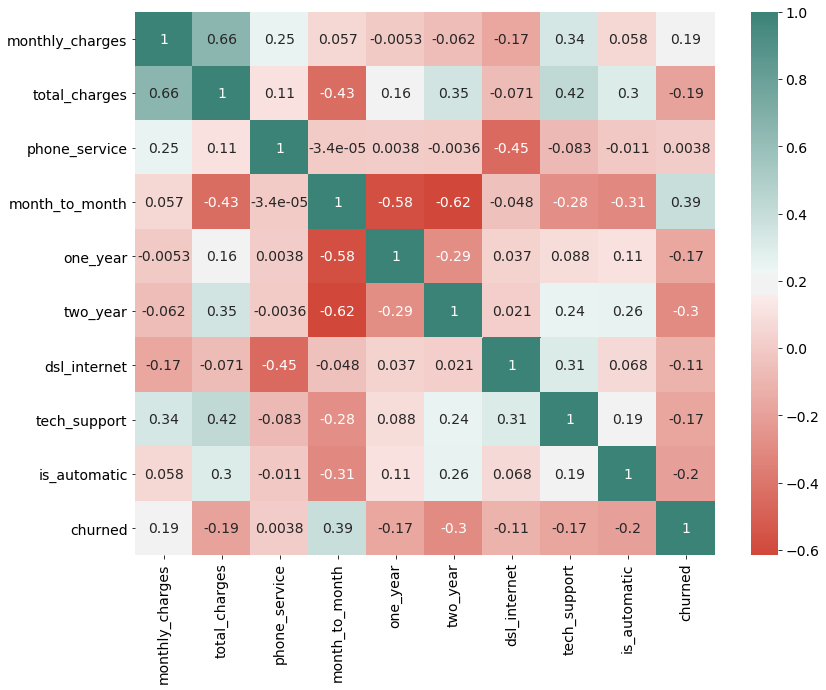

In [121]:
# Used the sns.heatmap's cmap function to adjust the colors to stand out more distinctly than the default.

cmap = sns.diverging_palette(15, 175, as_cmap = True)

sns.heatmap(corr2, annot = True, cmap = cmap)
plt.show()

#### Results:
- Monthly charges, total_charges, tech support use, and automatic billing all have strong negative correlations to a customer churning. Whether or not they have phone service isn't strongly correlated to churn based on this analysis.
- Month to Month contracts had a high positive correlation with churn, while two year contracts had a high negative correlation.
- I will be using Month to month, 2 year, and is_automatic data for my models.

## Hypothesis Testing:

#### Hypothesis #1:
- $H_0$: Customer churn is not related to (is independent of) contract type
- $H_a$: Customer churn is related to (is not independent of) contract type

In [31]:
# Setting overall confidence and alpha levels for all testing. My alpha level will not change past this point, regardless of what my models show.

confidence_level = .95
alpha = round(1 - confidence_level, 2)
alpha

0.05

In [32]:
df_explore.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,payment_type,internet_service_type,contract_type,month_to_month,one_year,two_year,dsl_internet,fiber_internet,no_internet,is_female,is_automatic,churned,t_yrs
5710,6013-BHCAW,Male,0,1,1,61,1,1,1,0,0,1,1,1,0,3,1,3,81.00,4976.15,No,Bank transfer (automatic),DSL,Two year,0,0,1,1,0,0,0,1,0,5.08
4465,0409-WTMPL,Female,0,1,0,58,1,1,2,1,1,1,0,1,0,2,1,4,110.65,6526.65,No,Credit card (automatic),Fiber optic,One year,0,1,0,0,1,0,1,1,0,4.83
5017,1085-LDWAM,Female,0,1,1,69,1,0,3,0,0,0,0,0,0,2,1,4,20.35,1442.65,No,Credit card (automatic),None,One year,0,1,0,0,0,1,1,1,0,5.75
3521,3039-MJSLN,Male,0,0,1,3,1,0,3,0,0,0,0,0,0,1,0,3,20.20,50.60,No,Bank transfer (automatic),None,Month-to-month,1,0,0,0,0,1,0,1,0,0.25
3828,9046-JBFWA,Male,0,0,1,27,1,0,3,0,0,0,0,0,0,1,0,2,19.15,537.35,No,Mailed check,None,Month-to-month,1,0,0,0,0,1,0,0,0,2.25


In [34]:
# contract type is independent of churn:
contract_test = df_explore[df_explore.contract_type == 'Month-to-month']
contract_test

churn_tab = pd.crosstab(contract_test.churn, contract_test.contract_type)
churn_tab

contract_type,Month-to-month
churn,
No,1269
Yes,919


In [35]:
# contract type is independent of churn:
contract_tab = pd.crosstab(df_explore.churn, df_explore.contract_type)
contract_tab

contract_type,Month-to-month,One year,Two year
churn,,,
No,1269,730,898
Yes,919,103,24


In [36]:
# Easy way from text:
# chi2, p, degf, expected = stats.chi2_contingency(observed)

chi2, p, degf, expected = stats.chi2_contingency(contract_tab)

print(f'p-value is: {p:.4}')
print(f'chi2 value is: {chi2:.4}')

if p < alpha:
    print("Our p-value is less than our alpha, thus the null hypothesis is rejected.")
else:
    print("Our p-value is greater than our alpha, thus we fail to reject the null hypothesis ")

p-value is: 1.655e-136
chi2 value is: 625.3
Our p-value is less than our alpha, thus the null hypothesis is rejected.


#### Hypothesis Test Result:

- Null hypothesis was rejected, meaning those variables were independent of churn. Can use those in modeling.

#### Hypothesis #2:
- $H_0$: Customer churn is not related to (is independent of) automatic payment type
- $H_a$: Customer churn is related to (is not independent of) automatic payment type

In [37]:
# How to create a dataframe from another set of columns:
df_explore_test2 = df_explore[['is_automatic']]
df_explore_test2.shape

(3943, 1)

In [38]:
# How to create a dataframe from another set of columns:
df_explore_test2 = df_explore[['is_automatic']]

# payment type is independent of churn:
payment_tab = pd.crosstab(df_explore.churn, df_explore.is_automatic)

# Easy way from text:
# chi2, p, degf, expected = stats.chi2_contingency(observed)

chi2, p, degf, expected = stats.chi2_contingency(payment_tab)

print(f'p-value is: {p:.4}')
print(f'chi2 value is: {chi2:.4}')

if p < alpha:
    print("Our p-value is less than our alpha, thus the null hypothesis is rejected.")
else:
    print("Our p-value is greater than our alpha, thus we fail to reject the null hypothesis ")

p-value is: 6.408e-35
chi2 value is: 152.0
Our p-value is less than our alpha, thus the null hypothesis is rejected.


In [39]:
# Easy way from text:
# chi2, p, degf, expected = stats.chi2_contingency(observed)

chi2, p, degf, expected = stats.chi2_contingency(payment_tab)

print(f'p-value is: {p:.4}')
print(f'chi2 value is: {chi2:.4}')

if p < alpha:
    print("Our p-value is less than our alpha, thus the null hypothesis is rejected.")
else:
    print("Our p-value is greater than our alpha, thus we fail to reject the null hypothesis ")

p-value is: 6.408e-35
chi2 value is: 152.0
Our p-value is less than our alpha, thus the null hypothesis is rejected.


#### Hypothesis Test Result:

- Null hypothesis was rejected, meaning those variables were independent of churn.

# Modeling

Using this Logistic Regression model first, then Decision Tree and finally KNN

## Logistic Regression Model

In [56]:
df = get_telco_data()
df = prep_telco_data_all(df)

In [57]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,payment_type,internet_service_type,contract_type,month_to_month,one_year,two_year,dsl_internet,fiber_internet,no_internet,is_female,is_automatic,churned
0,0003-MKNFE,Male,0,0,0,9,1,1,1,0,0,0,0,0,0,1,0,2,59.9,542.40,No,Mailed check,DSL,Month-to-month,1,0,0,1,0,0,0,0,0
1,0013-MHZWF,Female,0,0,1,9,1,0,1,0,0,0,1,1,0,1,1,4,69.4,571.45,No,Credit card (automatic),DSL,Month-to-month,1,0,0,1,0,0,1,1,0
2,0015-UOCOJ,Female,1,0,0,7,1,0,1,1,0,0,0,0,0,1,1,1,48.2,340.35,No,Electronic check,DSL,Month-to-month,1,0,0,1,0,0,1,0,0
3,0023-HGHWL,Male,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,1,25.1,25.10,Yes,Electronic check,DSL,Month-to-month,1,0,0,1,0,0,0,0,1
4,0032-PGELS,Female,0,1,1,1,0,0,1,1,0,0,0,0,0,1,0,3,30.5,30.50,Yes,Bank transfer (automatic),DSL,Month-to-month,1,0,0,1,0,0,1,1,1


In [58]:
# Variables assigned with my independent (inde) variable choices:
X_train_inde = df[['is_automatic', 'month_to_month', 'one_year', 'two_year', 'monthly_charges', 'total_charges']]
X_validate_inde = X_train_inde
X_test_inde = X_train_inde

# Defining the X and Y variables for my modeling
X_train_1 = train[['is_automatic', 'month_to_month', 'one_year', 'two_year', 'monthly_charges', 'total_charges']]
y_train_1 = train[['churned']]

X_validate_1 = validate[['is_automatic', 'month_to_month', 'one_year', 'two_year', 'monthly_charges', 'total_charges']]
y_validate_1 = validate[['churned']]

X_test_1 = test[['is_automatic', 'month_to_month', 'one_year', 'two_year', 'monthly_charges', 'total_charges']]
y_test_1 = test[['churned']]

In [77]:
# Basic logistic regression model to start:

# Only fit on my training dataset
logit = LogisticRegression(C = 1.0, random_state=123)

logit.fit(X_train_1, y_train_1)

# Train data prediction:
y_pred_1 = logit.predict(X_train_1)

# Now the est. of churn based on train predict:
y_pred_prob_1 = logit.predict_proba(X_train_1)

print('Accuracy of Logistic Classifier on training set: {:.2f}'
     .format(logit.score(X_train_1, y_train_1)))
print(classification_report(y_train_1, y_pred_1))

Accuracy of Logistic Classifier on training set: 0.79
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2897
           1       0.63      0.48      0.54      1046

    accuracy                           0.79      3943
   macro avg       0.73      0.69      0.70      3943
weighted avg       0.77      0.79      0.78      3943



## Random Forest Model

In [90]:
from sklearn.ensemble import RandomForestClassifier

In [91]:
# Defining the X and Y variables for my modeling
X_train_rf = train[['is_automatic', 'month_to_month', 'one_year', 'two_year', 'monthly_charges', 'total_charges']]
y_train_rf = train[['churned']]

In [92]:
# Using Random Forest Model
rf = RandomForestClassifier(bootstrap=True,
                            min_samples_leaf=10,
                            n_estimators=100,
                            max_depth=20, 
                            random_state=123)

# Fitting the model using the train data:
rf.fit(X_train_rf, y_train_rf)

# Making prediction:
y_pred_rf = rf.predict(X_train_rf)

# Estimating the probability of churn using the training dataset:
y_pred_proba_rf = rf.predict_proba(X_train_rf)


print('Accuracy of Random Forest Model on training set: {:.2f}'
     .format(logit.score(X_train_rf, y_train_rf)))
print(classification_report(y_train_rf, y_pred_rf))

Accuracy of Random Forest Model on training set: 0.79
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      2897
           1       0.74      0.57      0.64      1046

    accuracy                           0.83      3943
   macro avg       0.80      0.75      0.77      3943
weighted avg       0.83      0.83      0.83      3943



#### Results:
- Same accuracy as the logistic regression model.
- Slightly higher precision, recall, and f1-scores using this Random Forest Model.

#### Conclusion:
- Two Models are now run through the test set, I'll use both on the validation set to see which one is better.

## Model - Validation Stage

### Logistic Regression Model Validation

In [81]:
# Using the logistic regression model on the validate dataset:

# Train data prediction:
y_pred_val_1 = logit.predict(X_validate_1)

# Now the est. of churn based on train predict:
y_pred_prob_val_1 = logit.predict_proba(X_validate_1)

print('Accuracy of Logistic Classifier on validate set: {:.2f}'
     .format(logit.score(X_validate_1, y_validate_1)))
print(classification_report(y_validate_1, y_pred_val_1))

Accuracy of Logistic Classifier on validate set: 0.79
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1242
           1       0.63      0.50      0.56       449

    accuracy                           0.79      1691
   macro avg       0.73      0.70      0.71      1691
weighted avg       0.78      0.79      0.78      1691



In [93]:
### Random Forest Model Validation

In [94]:
X_val_rf = validate[['is_automatic', 'month_to_month', 'one_year', 'two_year', 'monthly_charges', 'total_charges']]
y_val_rf = validate[['churned']]

# Making prediction, but this time on the validate dataset:
y_pred_val_rf = rf.predict(X_val_rf)

# Estimating the probability of churn using the training dataset:
y_pred_proba_val_rf = rf.predict_proba(X_val_rf)


print('Accuracy of Random Forest Model on training set: {:.2f}'
     .format(logit.score(X_val_rf, y_val_rf)))
print(classification_report(y_val_rf, y_pred_val_rf))

Accuracy of Random Forest Model on training set: 0.79
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1242
           1       0.64      0.52      0.58       449

    accuracy                           0.80      1691
   macro avg       0.74      0.71      0.72      1691
weighted avg       0.79      0.80      0.79      1691



#### Results:
- Both models return almost exactly the same results.
- Since both models are so similar, I opted to test using the Logistic Regression Model.
    - Technically, the Random Forest model was slightly better, but they were so similar I felt I had to make a judgement call. In future I want to do more tweaking of the hyperparameters of the logistic regression model over the random forest model, hence my decision to stick with the LR model.

## Model Testing
In the testing step, only test the top model I've identified from the train and validate phases.

In [95]:
# Using the logistic regression model on the validate dataset:

# Train data prediction:
y_pred_test_1 = logit.predict(X_test_1)

# Now the est. of churn based on train predict:
y_pred_prob_test_1 = logit.predict_proba(X_test_1)

print('Accuracy of Logistic Classifier on test dataset: {:.2f}'
     .format(logit.score(X_test_1, y_test_1)))
print(classification_report(y_test_1, y_pred_test_1))

Accuracy of Logistic Classifier on test dataset: 0.80
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.47      0.55       374

    accuracy                           0.80      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.80      0.78      1409



## Model Evaluation

In [96]:

# The accuracy, precision and recall for predicting who will churn (churn = 0)
confusion_matrix(train.churned, y_pred_1)


array([[2602,  295],
       [ 545,  501]])

# Predicting Churn

#### Adding my model predictions to the original dataset.

In [84]:
# Create eval_df and rename the train survived column actual.
logit_train_df = df[['churn']].rename(columns={'churn': 'actual'})

# Predict whether a customer will churn using the X_train_inde data; add column to my logit_train_df
logit_train_df['yhat'] = logit.predict(X_train_inde)

# Estimate the probability of a customer churning using the X_train_inde data; add col to logit_train_df
logit_train_df['probs'] = logit.predict_proba(X_train_inde)[:, 1]

# Show the new eval df
logit_train_df.sample(10)

,actual,yhat,probs
3999,No,0,0.128573
5302,No,0,0.072296
86,No,1,0.624613
4399,No,0,0.068184
1900,No,0,0.342286
1577,No,0,0.420631
1240,No,1,0.561124
1377,Yes,1,0.705744
6426,No,0,0.014440
2488,Yes,1,0.624205


In [85]:
# Create eval_df and rename the train survived column actual.
logit_eval_df = df[['churn']].rename(columns={'churn': 'actual_churn'})

# Predict whether a customer will churn using the X_train_inde data; add column to my logit_train_df
logit_eval_df['yhat'] = logit_val.predict(X_train_inde)

# Estimate the probability of a customer churning using the X_train_inde data; add col to logit_train_df
logit_eval_df['probs'] = logit_val.predict_proba(X_train_inde)[:, 1]

# Add an identifier, the customer_id to the prediction dataframe:
logit_eval_df['customer_id'] = telco.customer_id

# Show the new eval df
logit_eval_df.sample(10)

,actual_churn,yhat,probs,customer_id
48,Yes,0,0.153569,0447-BEMNG
3829,Yes,0,0.150044,9063-ZGTUY
4006,No,0,0.183814,2364-UFROM
2339,No,0,0.420263,5146-CBVOE
6637,No,0,0.024467,3525-DVKFN
5052,No,0,0.062522,1952-DVVSW
6213,Yes,0,0.032082,5748-RNCJT
1976,No,0,0.434383,3481-JHUZH
6782,No,0,0.019209,5854-KSRBJ
6709,No,0,0.022105,4774-HHGGS


In [97]:
logit_eval_df.shape

(7043, 4)

In [98]:
print(df.shape)
print(logit_eval_df.shape)

(7043, 33)
(7043, 4)


In [88]:
logit_eval_df.to_csv('telco_predicted_churn.csv')

# Conclusions

- I have run a logistic regression model on the train, validate and test datasets, all of which have returned a better accuracy than my baseline model.
- My baseline model was 73% accurate at predicting churn, while my best model (logistic regression model) had an accuracy of 80% of predicting customer churn.
- **Recommendation:** The models showed that customers with an automatic payment plan tended to have a higher retention. Create discounts or promotions that would encourage customers to switch to an automatic payment plan. Would also recommend that any models we use as a prediction of churn should incorporate automatic vs manual payment plans into the training of the model.

#### Next Steps
- If I have more time I would like to go back and run more models using different algorithms, such as KNN and Decision Tree.
- Also if there were more time I would've gone back and done more exploration related to monthly costs by internet service, total costs by tenure cohort, and also use different hyperparameters to see if that increased the overall accuracy of my models.
- **One big takeaway** is that over the course of using my models on the train, validate, and test stages, the accuracy of the model remained withint 2-3 points of the training results. What this means to me is that I hopefully have a lower likelihood of having over-fitted my sample-data. 
- I anticipate the model will have similar accuracy on out of sample data once it become available.